# Jigsaw - Agile Community Rules Classification

> Using AI models to help moderators uphold community-specific norms.

Competition: https://www.kaggle.com/competitions/jigsaw-agile-community-rules

In [ ]:
import os
import gc
import kagglehub
import numpy as np
import pandas as pd
import transformers
import torch
import seaborn as sns

from datasets import Dataset, load_dataset
from pathlib import Path
from torch.nn.functional import softmax

COMPETITION_HANDLE = "jigsaw-agile-community-rules"
MODEL_HANDLE = "google/gemma-3/transformers/gemma-3-1b-it"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


## Setup

### Via Kaggle's UI

*Note that the UI might have changed since `2025-09-02`.*

The kaggle instance already has access to the competion data.

For the language models, we need GPU acceleration!

`Settings > Accelerator > GPU T4 x2`

Open the notebook sidetab:

`View > Show Sidebar`

You can add data and models via the `+ Add Input` button.
Search for Gemma 3 and add the 1b-it variant for the `transformers` Framework.
It should show up under: `/kaggle/input/gemma-3/transformers/gemma-3-1b-it/1`
You can also try other models, but be aware, that the kaggle instance has limited GPU memory.
Everything above `7b` will probably run into memory issues, unless the model is quantized.

![kaggle sidebar](screenshots/kaggle-input.png)

### Via KaggleHub

Alternatively, we can also use `kagglehub`, allowing us to keep the file paths consistent between kaggle's notebook environment and local execution.
However, we need to provide our login credentials for

1. If you don't have an API token yet, create a new one at: https://www.kaggle.com/settings/account
2. Provide your credentials in `~/.kaggle/kaggle.json` (where `~` is your home directory)

If you are using the devcontainer setup, you can also put your credentials in `.devcontainer/kaggle.env`.
This defines the environment variables `KAGGLE_USERNAME` and `KAGGLE_KEY` for `kagglehub` to use.

See [kagglehubs README](https://github.com/Kaggle/kagglehub) for more information.

Alternatively, you can run this cell to login:

In [2]:
try:
    # already logged in?
    whoami = kagglehub.whoami()
except kagglehub.exceptions.UnauthenticatedError:
    # otherwise login
    kagglehub.login()

Kaggle credentials successfully validated.


## Downloading Data and Models

In [3]:
DATA_PATH = Path(kagglehub.competition_download(COMPETITION_HANDLE))
print(DATA_PATH)

/root/.cache/kagglehub/competitions/jigsaw-agile-community-rules


In [4]:
LLM_PATH = Path(kagglehub.model_download(MODEL_HANDLE))
print(LLM_PATH)

/root/.cache/kagglehub/models/google/gemma-3/transformers/gemma-3-1b-it/1


## A first look at the Data

In [ ]:
# check data files
# could use DATA_PATH.walk(), but kaggle's pathlib version is too old
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        print(Path(dirname) / filename)

/root/.cache/kagglehub/competitions/jigsaw-agile-community-rules/sample_submission.csv
/root/.cache/kagglehub/competitions/jigsaw-agile-community-rules/test.csv
/root/.cache/kagglehub/competitions/jigsaw-agile-community-rules/train.csv
/root/.cache/kagglehub/competitions/jigsaw-agile-community-rules/tune_train.csv
/root/.cache/kagglehub/competitions/jigsaw-agile-community-rules/tune_test.csv
/root/.cache/kagglehub/competitions/jigsaw-agile-community-rules/tune_eval.csv


In [6]:
TRAIN_PATH = DATA_PATH / "train.csv"
TEST_PATH = DATA_PATH / "test.csv"
SAMPLE_PATH = DATA_PATH / "sample_submission.csv"


train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
sample_df = pd.read_csv(SAMPLE_PATH)

In [7]:
train_df.head()

,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,rule_violation
0,0,Banks don't want you to know this! Click here ...,"No Advertising: Spam, referral links, unsolici...",Futurology,If you could tell your younger self something ...,hunt for lady for jack off in neighbourhood ht...,Watch Golden Globe Awards 2017 Live Online in ...,"DOUBLE CEE x BANDS EPPS - ""BIRDS""\n\nDOWNLOAD/...",0
1,1,SD Stream [ ENG Link 1] (http://www.sportsstre...,"No Advertising: Spam, referral links, unsolici...",soccerstreams,[I wanna kiss you all over! Stunning!](http://...,LOLGA.COM is One of the First Professional Onl...,#Rapper \n🚨Straight Outta Cross Keys SC 🚨YouTu...,[15 Amazing Hidden Features Of Google Search Y...,0
2,2,Lol. Try appealing the ban and say you won't d...,No legal advice: Do not offer or request legal...,pcmasterrace,Don't break up with him or call the cops. If ...,It'll be dismissed: https://en.wikipedia.org/w...,Where is there a site that still works where y...,Because this statement of his is true. It isn'...,1
3,3,she will come your home open her legs with an...,"No Advertising: Spam, referral links, unsolici...",sex,Selling Tyrande codes for 3€ to paypal. PM. \n...,tight pussy watch for your cock get her at thi...,NSFW(obviously) http://spankbang.com/iy3u/vide...,Good News ::Download WhatsApp 2.16.230 APK for...,1
4,4,code free tyrande --->>> [Imgur](http://i.imgu...,"No Advertising: Spam, referral links, unsolici...",hearthstone,wow!! amazing reminds me of the old days.Well...,seek for lady for sex in around http://p77.pl/...,must be watch movie https://sites.google.com/s...,We're streaming Pokemon Veitnamese Crystal RIG...,1


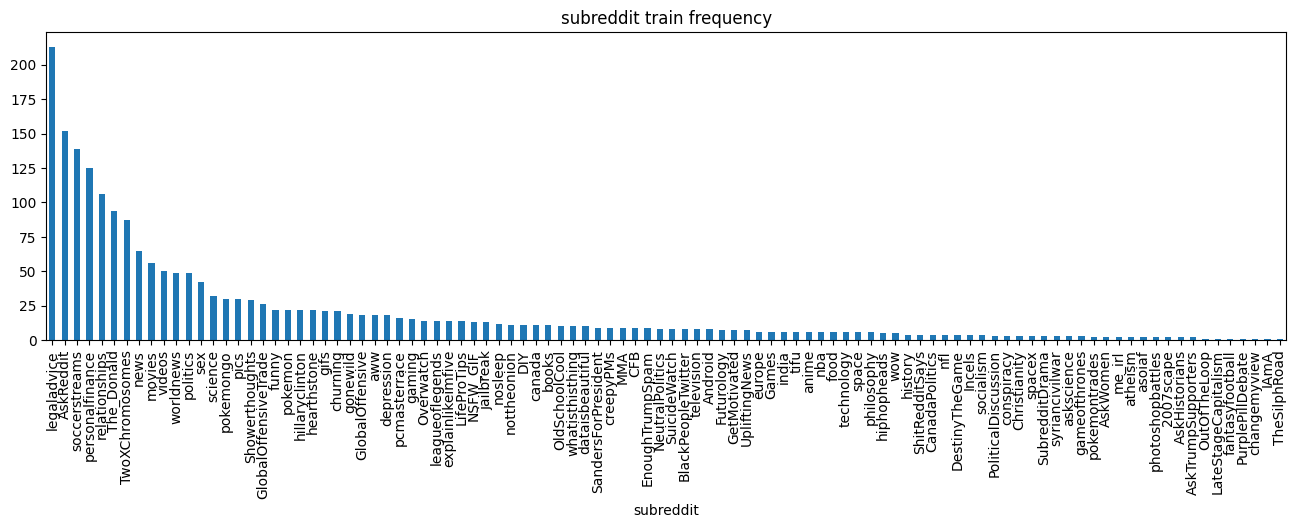

In [8]:
train_df["subreddit"].value_counts().plot.bar(figsize=(16,4), title="subreddit train frequency");


<Axes: title={'center': 'rule violations per subreddit'}, xlabel='subreddit'>

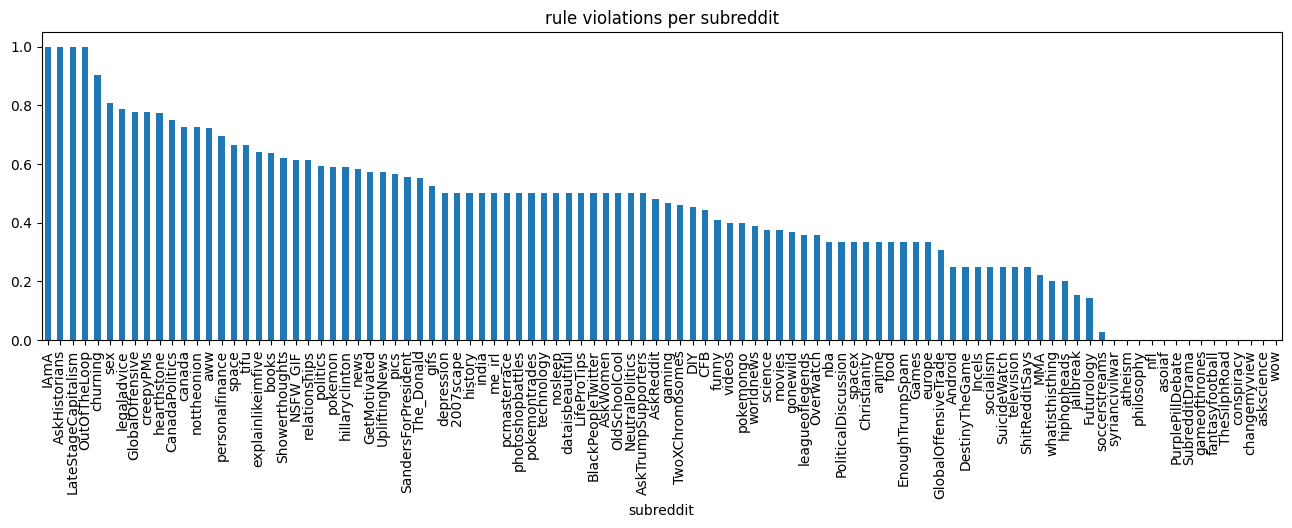

In [9]:
train_df.groupby("subreddit")["rule_violation"].mean().sort_values(ascending=False).plot.bar(figsize=(16,4), title="rule violations per subreddit")

In [12]:
# how many rules are there actually?
train_df["rule"].unique()

array(['No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.',
       'No legal advice: Do not offer or request legal advice.'],
      dtype=object)

In [60]:
# according to the competition's page, there are additional rules in the test set:
# > The training dataset contains only two rules. The test dataset contains additional rules that models must be able to generalize to.
# > (The number of unseen rules is not specified as part of the competition.)
# however, here, it does not seem like we have additional rules?

test_df["rule"].unique()

array(['No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.',
       'No legal advice: Do not offer or request legal advice.'],
      dtype=object)

In [13]:
train_df.groupby(["subreddit", "rule"])["row_id"].count().reset_index().pivot(index="rule", columns="subreddit", values="row_id")

violations_df = pd.crosstab(train_df["rule"], train_df["subreddit"], values=train_df["rule_violation"], aggfunc="mean")
violations_df = violations_df.reset_index().melt(id_vars="rule")

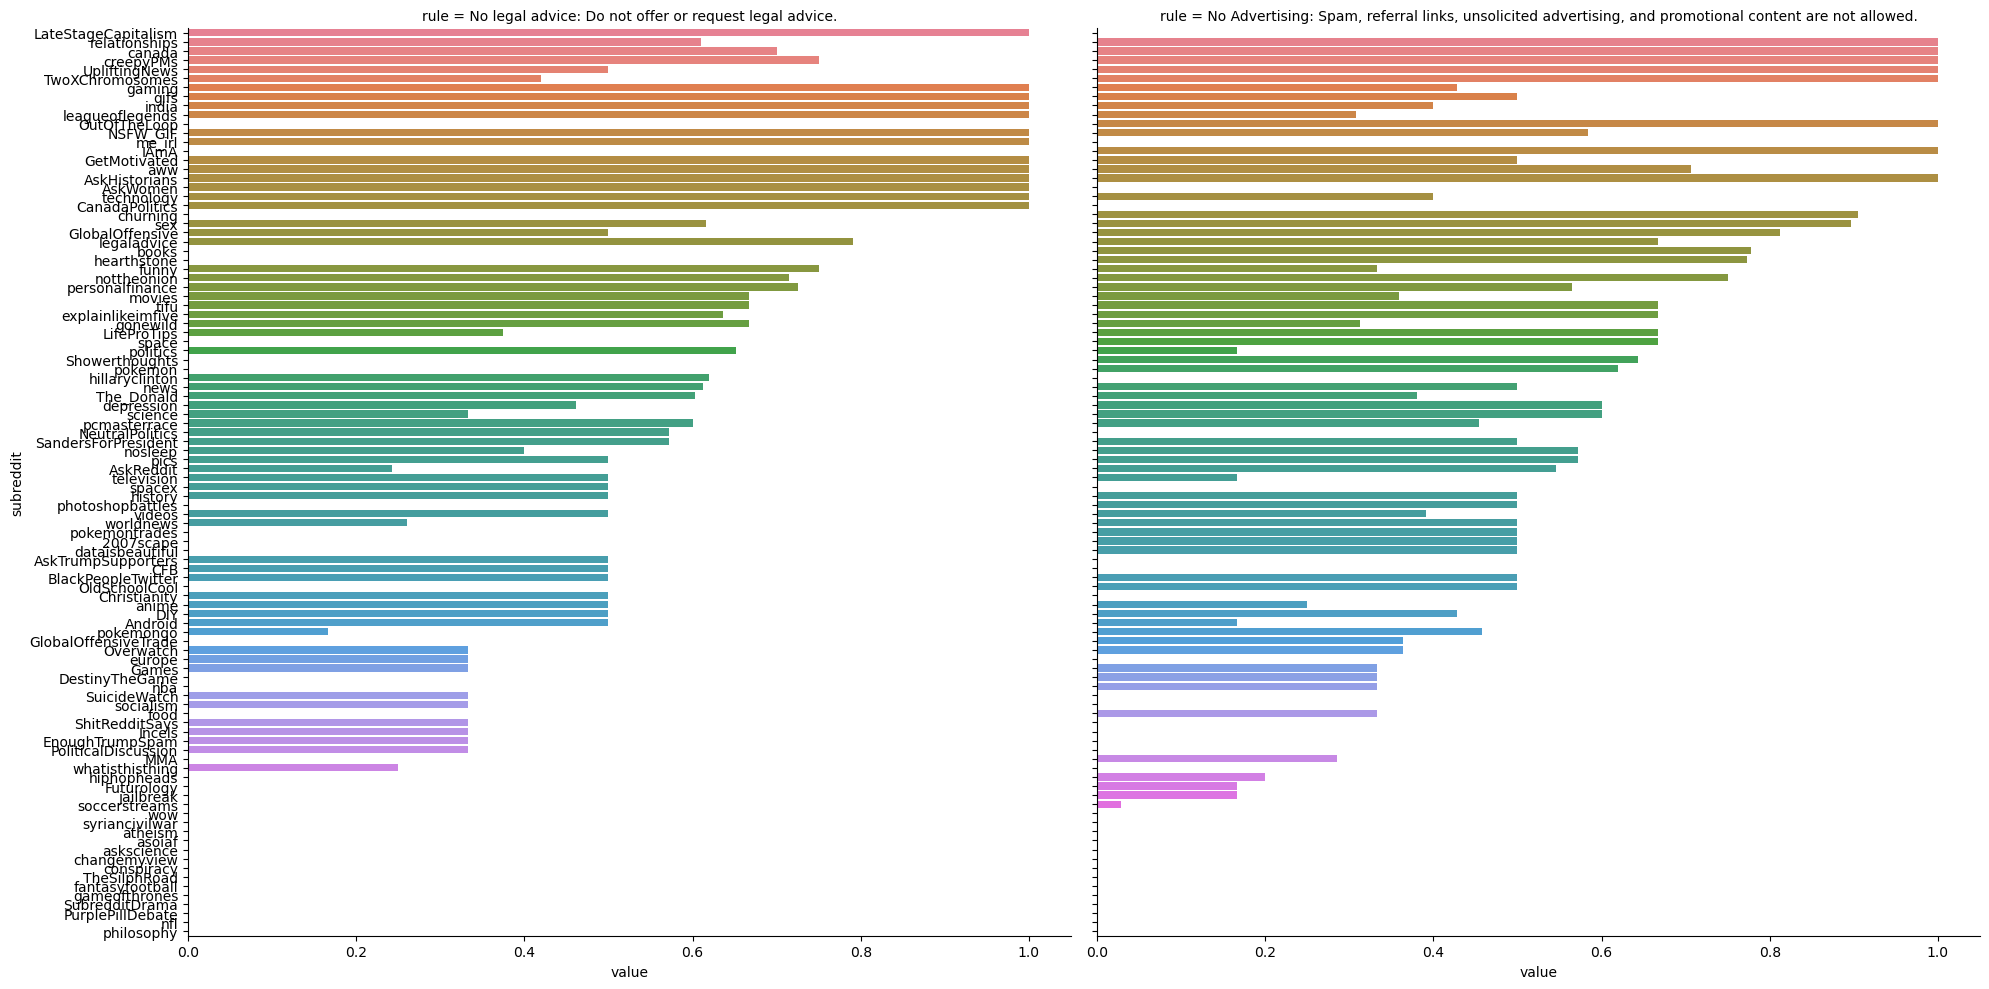

In [ ]:
import seaborn as sns

sns.catplot(violations_df.sort_values("value", ascending=False), y="subreddit", x="value", col="rule", kind="bar", height=10);

## Approach: Predict only on Subreddit

If each subreddit would have the same content, the same rules and the same moderators, we would expect the amount of rule violations to be similar across subreddits.
However, as we can see in the plot, this is not the case!
There are subreddits like `LateStageCapitalism` with 100% rule violation in the train data, while there isn't a single example for rule violation in other subreddits like `ask_science`.

This raises the question: How accurate will a classifier be that predicts only on the subreddit value?

In [15]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier

# need to onehot encode subreddit for DecisionTreeClassifier
x = pd.get_dummies(train_df["subreddit"])
y = train_df["rule_violation"]

tree_cv = cross_val_score(DecisionTreeClassifier(), x, y, cv=5)

print(f"mean accuracy of a decision tree predicting only on the subreddit: {tree_cv.mean() * 100:.2f} %")

mean accuracy of a decision tree predicting only on the subreddit: 61.85 %


In [16]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier

# will it improve if we also include the rule?
x = pd.concat(
    [
        pd.get_dummies(train_df["subreddit"]),
        pd.get_dummies(train_df["rule"])
    ],
    axis=1
)

y = train_df["rule_violation"]

tree_cv = cross_val_score(DecisionTreeClassifier(), x, y, cv=5)

print(f"mean accuracy of a decision tree predicting only on rule and subreddit: {tree_cv.mean() * 100:.2f} %")

mean accuracy of a decision tree predicting only on rule and subreddit: 62.20 %


## Approach: LLM Few-Shot Prompting

In [17]:
from transformers import AutoModelForCausalLM, AutoTokenizer

llm = AutoModelForCausalLM.from_pretrained(LLM_PATH)
tokenizer = AutoTokenizer.from_pretrained(LLM_PATH)

llm.to(DEVICE)

Gemma3ForCausalLM(
  (model): Gemma3TextModel(
    (embed_tokens): Gemma3TextScaledWordEmbedding(262144, 1152, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma3DecoderLayer(
        (self_attn): Gemma3Attention(
          (q_proj): Linear(in_features=1152, out_features=1024, bias=False)
          (k_proj): Linear(in_features=1152, out_features=256, bias=False)
          (v_proj): Linear(in_features=1152, out_features=256, bias=False)
          (o_proj): Linear(in_features=1024, out_features=1152, bias=False)
          (q_norm): Gemma3RMSNorm((256,), eps=1e-06)
          (k_norm): Gemma3RMSNorm((256,), eps=1e-06)
        )
        (mlp): Gemma3MLP(
          (gate_proj): Linear(in_features=1152, out_features=6912, bias=False)
          (up_proj): Linear(in_features=1152, out_features=6912, bias=False)
          (down_proj): Linear(in_features=6912, out_features=1152, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma3RMSNorm((11

In [62]:
# try out the llm
prompt = "Do you like Bratwurst?"

In [19]:
# apply tokenizer
input_ids = tokenizer.encode(prompt, return_tensors="pt")
input_ids

tensor([[     2, 222222, 236765,  69123]])

In [20]:
output_ids = llm.generate(input_ids.to(DEVICE))
output_ids

/opt/conda/lib/python3.12/site-packages/torch/_inductor/compile_fx.py:167: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


tensor([[     2, 222222, 236765,  69123,    563,    496,   4913,  52332,    699,
         119945, 236764,   9405, 236761,   1030, 236789, 236751,   3224,    573,
           1061,  29039, 236764,   8427,  44018,  18434]], device='cuda:0')

In [21]:
tokenizer.batch_decode(output_ids)

["<bos>bratwurst is a popular sausage from Bavaria, Germany. It's known for its distinctive, slightly spicy flavor"]

In [24]:
# you can use a pipeline object to simplify the prompting
from transformers.pipelines import pipeline

pipe = pipeline("text-generation", model=LLM_PATH)

Device set to use cuda:0


In [28]:
# however, we want the llm to answer our question instead of elaborating on it
# first of all, we need an instruction tuned (it) model
# then, we need to apply the chat template
chat = [
    { "role": "user", "content": prompt},
]

messages = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)

pipe(messages, max_new_tokens=50, return_full_text=False)

[{'generated_text': 'As an AI, I don’t have taste buds or the ability to eat, so I can’t *like* anything! 😊 \n\nHowever, I can tell you that Bratwurst is a *very* popular and beloved food in'}]

In [ ]:
def make_message(tokenizer, template, **kwargs):
    content = template.format(**kwargs)

    chat = [
        { "role": "user", "content": content},
    ]

    messages = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)

    return messages 

In [47]:
template_few_shot = """
You are a very serious and hard-working reddit mod from the {subreddit} subreddit and need to flag comments if they violate the following rule:
{rule}

Answer only with 'True', if they violate the rule, otherwise answer only with 'False'. Omit everything else.
Here are some examples to get you started:

# Example 1

Comment: {positive_example_1}
Output: True

# Example 2

Comment: {positive_example_2}
Output: True

# Example 3

Comment: {negative_example_1}
Output: False

# Example 4

Comment: {negative_example_2}
Output: False

# Test

Now it's your turn!

Comment: {body}
Output:
"""

In [69]:
from tqdm.notebook import tqdm

def predict_rows(df: pd.DataFrame, tokenizer, template, pipe):
    outputs = []
    total = len(df)
    for row_id, row in tqdm(df.iterrows(), total=total):
        messages = make_message(tokenizer, template, **row)
        output = pipe(messages, max_new_tokens=1, return_full_text=False)
        output = output[0]["generated_text"]
        outputs.append(output)
    return outputs

In [70]:
y_hat = predict_rows(test_df, tokenizer, template_few_shot, pipe)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
val_df = train_df.copy()

n_test = 100

x_df = val_df.drop(columns="rule_violation")[:n_test]
y_df = val_df["rule_violation"]

y_val_pred = predict_rows(x_df, tokenizer, template_few_shot, pipe)

  0%|          | 0/2029 [00:00<?, ?it/s]

<Axes: >

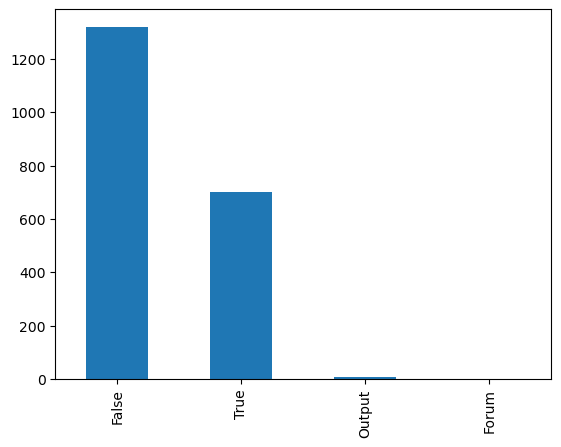

In [75]:
pd.Series(y_val_pred).value_counts().plot.bar()

In [ ]:
y_val = y_df.astype(bool).astype(str)[:n_test]

In [63]:
print("estimated accuracy of few shot approach")
(y_val == y_val_pred).mean()

estimated accuracy of few shot approach


NameError: name 'y_val' is not defined

In [ ]:
# clean up cuda memory
del pipe
del llm

gc.collect()
torch.cuda.empty_cache()

## Fine-Tuning

idea

- replace top layers with binary classification head
- fine tune our LLM on training data
    - actually, this would allow us to quintuple our training data, by also including positive and negative examples
    - could even include negative and positive examples from test data
- we need to create a custom huggingface dataset from the csv or a dictionary

## Load model

Unfortunately, `kagglehub` only provides the BERT model for the TensorFlow framework, missing Transformers.
However, `tensorflow` requires CUDA 12.3 - and we only have CUDA 12.2 available locally :(

If `tensorflow` would be available, we could use `transformers`' `TFAutoModelForSequenceClassification` to load tensorflow models into transformers:

![get the right model handle for kagglehub](screenshots/kaggle-bert.png)

```python
BERT_HANDLE = "tensorflow/bert/tensorFlow2/bert-en-uncased-l-10-h-128-a-2"
BERT_PATH = kagglehub.model_download(BERT_HANDLE)

from transformers import TFAutoModelForSequenceClassification

classifier = TFAutoModelForSequenceClassification.from_pretrained(BERT_PATH, num_labels=2)
```


But since tensorflow cannot be installed locally (sad), we will ditch kagglehub and use `transformers` to download the right version of the BERT model.

In [10]:
# add classification head to model

from transformers import AutoModelForSequenceClassification, AutoTokenizer

BERT_HANDLE = "bert-base-cased"

# instantiate BERT, but use 2 output classification head (num_labels=2)
classifier = AutoModelForSequenceClassification.from_pretrained(BERT_HANDLE, num_labels=2)
classifier.to(DEVICE)

tokenizer_bert = AutoTokenizer.from_pretrained(BERT_HANDLE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


When instantiating BERT, you will probably see a warning like: 

> Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
> You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

The pretrained BERT model already brings it's own classification head, which predicts which token is beneath the special `[MASK]`.
But since we only want to do binary classification if the reddit rule is violated or not, we replaced the classification head with just 2 output neurons.
However, the parameters (weights) of the classification head are now randomly initialized and not adjusted to the task at all.
If we would use the model as is, we will receive random Yes or No predictions for rule violations.

Therefore, we need to *fine-tune* the model to the downstream task on our dataset of reddit comments.

### Prepare the Data

Since we are now finetuning the model instead of doing few-shot In-Context-Learning, we don't actually need the positive and negative examples in the prompt.
However, instead of just discarding them, we could use them as additional training examples, effectively quintupling the size of our training dataset!
We will save this preprocessed dataset as csv.

We need to wrap our dataset in a `transformers` Dataset object, which the Trainer expects.
Then, we need to construct the right input prompts given our features.

In [11]:
tune_train_df = train_df.rename(columns={"rule_violation": "labels"}).melt(id_vars=["row_id", "rule", "subreddit", "labels"])

positive_mask = tune_train_df["variable"].str.contains("positive")
negative_mask = tune_train_df["variable"].str.contains("negative")

tune_train_df.loc[negative_mask, "labels"] = 0
tune_train_df.loc[positive_mask, "labels"] = 1

tune_train_df.head()

,row_id,rule,subreddit,labels,variable,value
0,0,"No Advertising: Spam, referral links, unsolici...",Futurology,0,body,Banks don't want you to know this! Click here ...
1,1,"No Advertising: Spam, referral links, unsolici...",soccerstreams,0,body,SD Stream [ ENG Link 1] (http://www.sportsstre...
2,2,No legal advice: Do not offer or request legal...,pcmasterrace,1,body,Lol. Try appealing the ban and say you won't d...
3,3,"No Advertising: Spam, referral links, unsolici...",sex,1,body,she will come your home open her legs with an...
4,4,"No Advertising: Spam, referral links, unsolici...",hearthstone,1,body,code free tyrande --->>> [Imgur](http://i.imgu...


In [12]:
tune_train_df.groupby("variable")["labels"].value_counts()

variable            labels
body                1         1031
                    0          998
negative_example_1  0         2029
negative_example_2  0         2029
positive_example_1  1         2029
positive_example_2  1         2029
Name: count, dtype: int64

In [23]:
TUNE_PATH = Path("data/tune/")
TUNE_PATH.mkdir(exist_ok=True, parents=True)

TUNE_TRAIN_PATH = TUNE_PATH / "tune_train.csv"

tune_train_df.to_csv(TUNE_TRAIN_PATH, index=False)

In [14]:
tune_eval_df = test_df.drop(columns="body").melt(id_vars=["row_id", "rule", "subreddit"])

positive_mask = tune_eval_df["variable"].str.contains("positive")
negative_mask = tune_eval_df["variable"].str.contains("negative")

tune_eval_df.loc[negative_mask, "labels"] = 0
tune_eval_df.loc[positive_mask, "labels"] = 1

tune_eval_df["labels"] = tune_eval_df["labels"].astype(int)

tune_eval_df.head()

,row_id,rule,subreddit,variable,value,labels
0,2029,"No Advertising: Spam, referral links, unsolici...",hiphopheads,positive_example_1,"Hey, guys, just wanted to drop in and invite y...",1
1,2030,No legal advice: Do not offer or request legal...,AskReddit,positive_example_1,Get a lawyer and get the security camera foota...,1
2,2031,"No Advertising: Spam, referral links, unsolici...",gonewild,positive_example_1,Good story my friend. Check out my blog at ht...,1
3,2032,"No Advertising: Spam, referral links, unsolici...",personalfinance,positive_example_1,"Earn 50,000 bonus points with Chase Sapphire P...",1
4,2033,"No Advertising: Spam, referral links, unsolici...",Showerthoughts,positive_example_1,code free tyrande --->>> [Imgur](http://i.imgu...,1


In [24]:
TUNE_EVAL_PATH = DATA_PATH / "tune_eval.csv"

tune_eval_df.to_csv(TUNE_EVAL_PATH, index=False)

In [25]:
example_cols = [c for c in test_df.columns if "example" in c]
tune_test_df = test_df.drop(columns=example_cols).melt(id_vars=["row_id", "rule", "subreddit"])

tune_test_df.head()

,row_id,rule,subreddit,variable,value
0,2029,"No Advertising: Spam, referral links, unsolici...",hiphopheads,body,NEW RAP GROUP 17. CHECK US OUT https://soundcl...
1,2030,No legal advice: Do not offer or request legal...,AskReddit,body,Make your life comfortable. Get up to 15% Disc...
2,2031,"No Advertising: Spam, referral links, unsolici...",gonewild,body,Kickin' ass and selling underwear!\nJust made ...
3,2032,"No Advertising: Spam, referral links, unsolici...",personalfinance,body,watch hooters best therein http://clickan...
4,2033,"No Advertising: Spam, referral links, unsolici...",Showerthoughts,body,bitches for free at this point show all h...


In [26]:
TUNE_TEST_PATH = DATA_PATH / "tune_test.csv"

tune_test_df.to_csv(TUNE_TEST_PATH, index=False)

In [27]:
from datasets import Dataset, load_dataset

tune_ds = load_dataset("csv", data_files={
    "train": str(TUNE_TRAIN_PATH),
    "eval": str(TUNE_EVAL_PATH),
    "test": str(TUNE_TEST_PATH)
})

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Great, now we need to map our prompt template and the tokenizer on each example:

In [28]:
def apply_template(example):
    template = """\
    [RULE]
    {rule}
    [CONTENT]
    {value}
    """
    example["prompt"] = template.format(rule=example["rule"], value=example["value"])
    return example

tune_ds = tune_ds.map(apply_template)

print(tune_ds["train"][0]["prompt"])

Map:   0%|          | 0/10145 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

    [RULE]
    No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.
    [CONTENT]
    Banks don't want you to know this! Click here to know more!
    


In [29]:
def apply_tokenizer(examples):
    return tokenizer_bert(examples["prompt"], padding="max_length", truncation=True)

tune_ds = tune_ds.map(apply_tokenizer, batched=True)

print(tune_ds["train"][0]["input_ids"])

Map:   0%|          | 0/10145 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

[101, 164, 155, 2591, 17516, 166, 1302, 25010, 131, 23665, 1306, 117, 5991, 4412, 6743, 117, 8362, 24313, 22308, 1174, 6437, 117, 1105, 10626, 3438, 1132, 1136, 2148, 119, 164, 18732, 15681, 11680, 1942, 166, 10117, 1274, 112, 189, 1328, 1128, 1106, 1221, 1142, 106, 140, 13299, 1303, 1106, 1221, 1167, 106, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Finetuning BERT

In [ ]:
from transformers import TrainingArguments, Trainer

import evaluate

metric = evaluate.load("accuracy")

training_args = TrainingArguments(
    output_dir="models/bert_reddit_classifier",
    eval_strategy="epoch"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


trainer = Trainer(
    model=classifier,
    args=training_args,
    train_dataset=tune_ds["train"],
    eval_dataset=tune_ds["eval"],
    compute_metrics=compute_metrics
)

In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

### Predict on Test examples

In [ ]:
pred = trainer.predict(tune_ds["test"])
pred_labels = np.argmax(pred.predictions, axis=1)

pred_p = softmax(torch.from_numpy(pred.predictions), dim=1).numpy()[:, 1]
pred_p

array([4.4121317e-04, 5.1397510e-04, 9.9922073e-01, 9.9939501e-01,
       9.9940836e-01, 4.1847720e-04, 9.9904376e-01, 4.1094175e-04,
       4.5750689e-04, 9.9927884e-01], dtype=float32)

In [61]:
submission_df = sample_df.copy()
submission_df["rule_violation"] = pred_p

submission_df.to_csv("submission.csv", index=False)

## Bookmarks

- https://github.com/Kaggle/kagglehub
- https://huggingface.co/
- https://huggingface.co/docs/transformers/en/training
- https://huggingface.co/google-bert/bert-base-uncased